In [ ]:
# https://www.kaggle.com/datasets/puneet6060/intel-image-classification

# Step 1: Import Libraries

In [5]:
# Libraries
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
from torch.nn import Linear

from torchvision.datasets import ImageFolder
from torchvision.models.vgg import vgg11
from torchvision.transforms import transforms

import numpy as np
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image 

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 2: Data Loader

In [6]:
# Train and Test Root

TRAIN_PATH = "seg_train/seg_train/"
TEST_PATH = "seg_test/seg_test/"

In [7]:
# Create Transformer Object

tfm_obj = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Create Data Loader
train_loader = DataLoader(
    ImageFolder(root=TRAIN_PATH, transform=tfm_obj), batch_size=30, shuffle=True
)
test_loader = DataLoader(
    ImageFolder(root=TEST_PATH, transform=tfm_obj), batch_size=30, shuffle=True
)

# Step 3: Create Model

In [8]:
# Instantiate the Model 
model = vgg11(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [9]:
# Replace the final layer neurons with number of classes in our dataset (i.e. 6)
model.classifier[6] = Linear(in_features=4096, out_features=6)
model = model.to(device)

# Step 4: Train and Evaluate the Model

In [12]:
# CONSTANTS
EPOCHS = 5
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
loss_fn = nn.CrossEntropyLoss()
TRAIN_COUNT, TEST_COUNT = len(ImageFolder(TRAIN_PATH)), len(ImageFolder(TEST_PATH))

In [13]:
# TRAIN & TEST MODEL

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(EPOCHS):
    start = time()
    
    tr_acc = 0
    tst_acc = 0
    
    # Train
    
    model.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            xtrain = xtrain.cuda()
            optimizer.zero_grad()
            train_output = model(xtrain)
            train_output = train_output.cpu()
            loss = loss_fn(train_output, ytrain)
            loss.backward()
            optimizer.step()

            ytrain_pred = torch.max(train_output,1).indices
            tr_acc += int(torch.sum(ytrain_pred == ytrain))
    
    # Evaluate
    
    model.eval()
    with torch.no_grad():
        for xtest, ytest in test_loader:
            xtest = xtest.cuda()
            test_output = model(xtest)
            test_output = test_output.cpu()
            test_loss = loss_fn(test_output, ytest)
            ytest_pred = torch.max(test_output, 1).indices
            tst_acc += int(torch.sum(ytest_pred == ytest))

    ep_tr_acc = tr_acc / TRAIN_COUNT
    ep_tst_acc = tst_acc / TEST_COUNT

    train_loss_list.append(loss)
    train_acc_list.append(ep_tr_acc)

    test_loss_list.append(test_loss)
    test_acc_list.append(ep_tst_acc)
        
    end = time()
    
    duration = (end-start)/60
    
    print(f"Ep: {epoch}, time_cost: {duration},\n tr_loss: {loss}, tst_loss: {test_loss},\n tr_acc: {ep_tr_acc}, tst_acc: {ep_tst_acc}")

100%|██████████| 468/468 [02:02<00:00,  3.82batch/s]


Ep: 0, time_cost: 2.2866632461547853,
 tr_loss: 0.17394177615642548, tst_loss: 0.1496601551771164,
 tr_acc: 0.8119566766424398, tst_acc: 0.8483333333333334


100%|██████████| 468/468 [02:01<00:00,  3.84batch/s]


Ep: 1, time_cost: 2.275935781002045,
 tr_loss: 1.0971077680587769, tst_loss: 0.5698986649513245,
 tr_acc: 0.8354709990024227, tst_acc: 0.7776666666666666


100%|██████████| 468/468 [02:01<00:00,  3.84batch/s]


Ep: 2, time_cost: 2.276253588994344,
 tr_loss: 0.4057497978210449, tst_loss: 0.3980211615562439,
 tr_acc: 0.8451617500356278, tst_acc: 0.8403333333333334


100%|██████████| 468/468 [02:01<00:00,  3.84batch/s]


Ep: 3, time_cost: 2.285408600171407,
 tr_loss: 0.629934549331665, tst_loss: 0.3430274724960327,
 tr_acc: 0.8601966652415562, tst_acc: 0.858


100%|██████████| 468/468 [02:01<00:00,  3.85batch/s]


Ep: 4, time_cost: 2.2713659524917604,
 tr_loss: 0.1827244609594345, tst_loss: 0.5637221932411194,
 tr_acc: 0.864329485535129, tst_acc: 0.8666666666666667


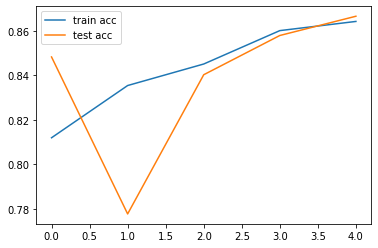

In [20]:
# Train Metrics
# Loss

plt.plot(range(EPOCHS),train_acc_list, label="train acc")

plt.plot(range(EPOCHS),test_acc_list, label="test acc")
plt.legend()

# Model Performance Demonstration

In [15]:
# Index mapping for the dataframe

idx_to_class = {0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [18]:
sample_image_1 = "seg_pred/seg_pred/10021.jpg"
sample_image_2 = "seg_pred/seg_pred/10038.jpg"
sample_image_3 = "seg_pred/seg_pred/10409.jpg"
sample_image_4 = "seg_pred/seg_pred/10768.jpg"

img_list = [sample_image_1, sample_image_2, sample_image_3, sample_image_4]

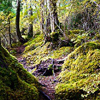

forest


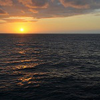

sea


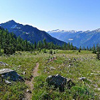

mountain


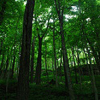

forest


In [19]:
# Model Performance
for img_path in img_list:
    img = Image.open(img_path)
    display(img.resize((100, 100)))
    img_tensor = tfm_obj(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    prob = model(img_tensor)
    pred = torch.max(prob, 1).indices
    pred = pred.item()
    print(idx_to_class[pred])
    print("====================================")

---
## Author:
Notebook by Shounak Deshpande<br>
Email: shounak.python@gmail.com